# PIA - Reinforcement Learning

1. RL Intro
2. Dynamic Programing
3. Tabular Q-Learning
4. **Deep Reinforcement Learning (DQN)**

## 4. Deep Reinforcement Learning (DQN)

Welcome to the final Reinforcement Learning Notebook. In this part you will implement the Deep Q-Learning Algorithm that was used by Mnih et al. to play Atari Video games. The resulting agent is called Deep Q-Network agent (or shorter DQN agent) because it uses a Deep Neural Network to approximate the value function (instead of saving it in a table).

---
### Course of Action

* Please write all executable python code in ```Code```-Cells (```Cell```->```Cell Type```->```Code```) and all Text as [Markdown](http://commonmark.org/help/) in ```Markdown```-Cells
* Describe your thinking and your decisions (where appropriate) in an extra Markdown Cell or via Python comments
* In general: discuss all your results and comment on them (are they good/bad/unexpected, could they be improved, how?, etc.). Furthermore, visualise your data (input and output).
* Write a short general conclusion at the end of the notebook
* Further experiments are encouraged. However, don't forget to comment on your reasoning.
* Use a scientific approach for all experiments (i.e. develop a hypothesis or concrete question, make observations, evaluate results)

### Submission

Upload the complete Notebook (and an exported html version) to Ilias before the deadline. One Notebook per Group is enough. Edit the teammember table below.

**Important**: Also attach a HTML version of your notebook (```File```->```Download as```->```HTML```) in addition to the ```.ipynb```-File.

| Teammember |                    |
|------------|--------------------|
| 1.         | Patrick Singer      |
| 2.         | Milos Aleksic         |

<font color="blue">
For better differentiation, all added comments from us will be marked in blue color.</font>

## Prerequisites

- **INSTALL**: [Gymnasium](https://github.com/Farama-Foundation/Gymnasium) - minimal install should be enough.
- The notebook is pretty self contained and includes all relevant theory. However, make sure that you have **read** and *understood* a corresponding lecture at least once! The notebook can only provide a short recap. Being prepared will help you to finish the notebook in time!
- Some good reading resources are:

    1. Johannes Maucher's [lecture on RL](https://gitlab.mi.hdm-stuttgart.de/maucher/ML/-/blob/master/Slides/V12Reinforcement.pdf) - chapter 4,5 & **6**.
    2. David Silver's course on RL: [Lecture 6](https://www.davidsilver.uk/teaching/): [Youtube](https://www.youtube.com/watch?v=UoPei5o4fps), [Lecture 9](https://www.davidsilver.uk/teaching/): [Youtube](https://www.youtube.com/watch?v=sGuiWX07sKw&list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ&index=9).
    3. Sutton & Barto: [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html) chapter **16.5**, further reading and more details chapters 9,10 & 11 (complete online pdf draft available).
    4. Read the original DQN papers:
        - NIPS 2013 - [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)
        - Nature 2015 - [Human Level Control Through Deep Reinforcement Learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning/)

---

## Theory

In the last notebook you have implemented the model-free **Q-Learning** algorithm and solved the *full reinforcement learning problem* by **learning from samples**. In this context, *full* refered to the fact that we dont have access to the world model and *model-free* to the fact that we have not tried to learn that model. Furthermore, Q-Learning performed **online** updates to the policy, meaning that we have adjusted the policy *online* after every time step. Finally Q-Learning is an **off-policy** algorithm because we followed an e-greedy behavior policy while we have performed updates according to a greedy target policy. Now we will tackle the **curse of dimensionality** by **approximating the value function** instead of saving it explicitly in a table.

### Case Study - Video Games

<img src="./RL_pics/Atari_games.png" alt="DQN" style="width: 1000px;"/>

Before we proceed to the solution, let us quickly revise the actual problem that we are trying to solve. Consider the task of learning to play a video game given only the raw game screen as input. This is similar to how humans would play the game. Since the game screen is typically represented as raw pixels, this leaves us with a really high dimensional input or state space because every change of pixels represents a new and distinct state of the game, even if the change seems completely insignificant to you! Remember, the agent has no real knowledge of the game (or world model). Clearly it is infeasible to store every possible state of pixle combinations in a table. See [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html) chapter 16.5 for a comprehensive discussion.   

<img src="./RL_pics/DQN_principle.png" alt="DQN" style="width: 800px;"/>

> The problem that is solved by Deep Reinforcement Learning (in the case by DQN) is how to learn a mapping from a high dimensional input space to action values. This mapping represents the value function and can be used in a policy, e.g. to choose the best action with the highest value.


### Nonlinear Function Approximation with Artificial Neural Networks

First of all, a lookup table can mathematically be seen as a very simple form of a function, i.e. a direct mapping of values (hence the name value function). However, for the reasons explained above, this approach does not scale to high dimensional input spaces. A typical solution to this problem is to replace the *perfect* but intractable lookup table with a more complicated function that *only* **approximates the true value function** but is computationally tractable. In the case of DQN we choose a deep neural network as our function approximator. Formally, this new function is denoted as $\hat{Q}$ and we write

$$\begin{eqnarray} 
\hat{Q}(s,a,\theta) \approx Q_{\pi}(s,a)
\end{eqnarray}$$

where $\theta$ are the parameters of the neural network. In other words, the value function now depends on those parameters and the task of finding and optimal value function turns into the task of finding an optimal set of parameters for the network. Fortunately, we know how to train and optimize a neural network with SGD and backpropagation given an appropriate loss function. **Inside the RL-framework we can use the TD-error as the loss function**. Formally we optimize:  

$$\begin{eqnarray} 
L_i(\theta_{i}) = \Big( \underbrace{r_{t+1} + \gamma \max_a Q(s_{t+1}, a; \theta_i) - Q(s_t, a_t;\theta_i)}_{TD-error} \Big)^2
\end{eqnarray}$$

> Note that in order to obtain any action-values, we now need to perform a forward pass through the network. In practice, this means two forward passes before we can calculate the loss, one pass for the value of $Q(s_t, a_t;\theta_i)$ and another one to calculate the value of $\max_a Q(s_{t+1}, a; \theta_i)$. More details on that later.


### Instabilities and Solutions

So far, so good. By using the TD-error as loss function we can train the network in a supervised learning like setup. Sadly it is not that easy. Remember that in supervised learning we assumed the data to be *independent and identically distributed* (iid-data) in order for SGD to work properly. This assuption does not hold in reinforcement learning where subsequent data is highly correlated and in contrast, depends strongly on the agents last choice of actions. This inherent sequential property, in combination with an off-policy algorithm and a non-linear function appoximator such as a neural network, results in the problem that the learnable network parameters are at risk to oscillate or even diverge catastrophically during training. In theory, there is no convergence guarantee whatsoever. In practice, Mnih et al. found two major ways in which the training process can be stabilized:

- **Experience Replay** - This idea introduces a so called **replay buffer** $\mathcal{D}$ which stores the last $N$ state transitions as experience tuples $(S,A,R,S')$. In other words, the agent saves its recent history to a buffer. This way, experience can be reused and the correlation between samples can be broken by **drawing random minibatches** of experience $U(\mathcal{D})$ from it during the training.
<br><br>

- **Fixed Q-Targets** - The second idea is to keep **a separate set of parameters** $\theta^{−}$ for calculating the **TD target**. This set is basically a copy of $\theta$ that is held fixed for some time $t$ and periodically gets swapped with the current parameter values in order to allow progress. Mnih et al. have shown that updating $\theta$ towards such fixed Q-targets is another effective way to stabilize the training process. In practice, this means that we have basically two separate networks which we will distinguish by their different set of parameters $\theta^{-}$ and $\theta$. We will refer to them respectively as **Target-** and **Q-Network**.

As a result, the **Q-learning update** of DQN at iteration $i$ uses the following loss function: 

$$\begin{eqnarray} 
L_i(\theta_{i}) = \mathbb{E}_{(s,a,r,s') \sim U(\mathcal{D})} \Bigg[ \Bigg( r_{t+1} + \gamma \max_a \underbrace{Q(s_{t+1}, a; \theta^{-}_{i})}_{Target-Network} - \underbrace{Q(s_t, a_t;\theta_i)}_{Q-Network} \Big)^2 \Bigg]
\end{eqnarray}$$

And thats it! We can use this update rule inside the Q-Learning algorithm to train a Deep Q-Network with SGD as we do in supervised learning. The corresponding **Deep Q-Learning algorithm** is given in the next part.

---

## Implementation

As in the previous notebooks we will implement the DQN algorithm step by step. While the original DQN architecture was a CNN trained on Atari games, we will choose a much simpler problem and architecture. This way you can verify and debug your implementation much faster (in minutes vs hours...). However, the algorithm itself is still the same and extending it should be straightforward after completing the notebook. Though, this is left to the *further ideas part* depending on your time and motivation.

The following is an overview of all the parts you need. Use it as a checklist if you get lost. Like with Q-Learning, try first to verify that all the sub-parts are working as expected. If you are confident, integrate them iteratively into the main loop. There is no single best approach how to proceed so feel free to jump back and forth between the cells as you like.

##### Overview

- The Gymnasium Environment
- Replay Buffer
- Epsilon Schedule
- Deep Q-Network
- E-Greedy Policy (action selection)
- Update the Target Network
- Train Method
- Main Loop
- Evaluation of Deep Reinforcement Learning Algorithms



### The Open AI Gym Environment

You will use the Gymnasium environment to solve a classic control task known as **Cart Pole Balance**. The great thing about the gym environment is that it offers a common interface to [many different environments](https://gymnasium.farama.org/environments/classic_control/). That way you can easily test your algorithms on different tasks, e.g. switch from an easy one like CartPole to more challenging ones like an Atari game etc. ;)

For now, we will solve the **CartPole-v1** task. 

1. First of all, [go and read](https://gymnasium.farama.org/environments/classic_control/cart_pole/) about its most important details such as the *observations, actions, rewards,* it's *max length* etc.
2. Second, get used to the gym interface. Run a random agent for some episodes etc. The most important API calls are:
    - `gym.make('CartPole-v1')` returns a new `game`.
    - The `make` function also takes an argument [`render_mode=`](https://gymnasium.farama.org/api/env/#gymnasium.Env.render). You can set it to the string `'human'` if you want to see the agent play or `None` if you don't need it, e.g. during training.
    - The game's `action_space` and `observation_space` variables.
    - `reset()` - returns an initial `observation` and some debug/game `info`.
    - `step()`  - takes an `action` int, returns an `observation, reward, game_over, truncated, info` tuple.
    - `close()` - call this after the last episode has ended to clean up.

<font color="blue"><b>Comment:</b></font> The variable `only_functions` was defined to omit retraining and evaluation tasks in the notebook when restarting the kernel.

In [1]:
only_functions = False

In [2]:
import gymnasium as gym
import numpy as np
import time
import random

<font color="blue"><b>Comment:</b></font> As a first test we ran a random agent on the Cartpole Gym Environment to verify if everything works.

In [3]:
if not only_functions:
    # Creating a test game
    test_game = gym.make('CartPole-v1', render_mode="human")
    print("Action Space:\n", test_game.action_space)
    print("Observation Space:\n", test_game.observation_space)

    # Running a random agent on the gym environment
    obs, info = test_game.reset()
    game_over, i = False, 1
    while not game_over:
        obs, reward, game_over, truncated, info = test_game.step(action=random.randint(0, 1))
        print(f"Round {i}: reward:{reward}, game_over:{game_over}")
        i += 1
        time.sleep(.1)
    test_game.close()

Action Space:
 Discrete(2)
Observation Space:
 Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Round 1: reward:1.0, game_over:False
Round 2: reward:1.0, game_over:False
Round 3: reward:1.0, game_over:False
Round 4: reward:1.0, game_over:False
Round 5: reward:1.0, game_over:False
Round 6: reward:1.0, game_over:False
Round 7: reward:1.0, game_over:False
Round 8: reward:1.0, game_over:False
Round 9: reward:1.0, game_over:False
Round 10: reward:1.0, game_over:False
Round 11: reward:1.0, game_over:False
Round 12: reward:1.0, game_over:False
Round 13: reward:1.0, game_over:False
Round 14: reward:1.0, game_over:False
Round 15: reward:1.0, game_over:False
Round 16: reward:1.0, game_over:False
Round 17: reward:1.0, game_over:False
Round 18: reward:1.0, game_over:False
Round 19: reward:1.0, game_over:True


### Replay Buffer

The replay buffer should store the last $N$ experience tuples. This is basically a FIFO queue and practically, [python offers such a data structure called](https://docs.python.org/3/library/collections.html#collections.deque) `deque`. If initialized with a `maxlen` parameter, `deque`'s `append` method will pop items from the left automatically when the list grows beyond the given `maxlen`. This is exactly what we want and **you can implement it in just a few lines of code!** The replay buffer should have the following methods:

- A constructor (`__init__`) that initializes an internal `deque` with a given `maxlen` or $N$ or better, call it `buffer_size`.

- A method `add` that appends a new experience tuple as list `[state, action, reward, next_state, done]` (`done` is the `game_over` information). 
  - **IMPORTANT:** cast the `reward` and `done` values with `np.float32(x)` to make keras happy later :)
- A method `sample` that returns random batchs of training data (of size `batch_size`). 
    1. You can use `random`'s `sample` method to get random experience tuples.
    2. The batch should be reshaped to separate batches: `[observations],[actions],[rewards]` etc. See the zip demo how you can achive this. Also, make them numpy arrays so keras is happy later, e.g. by using `map(np.array, )` on the zip output.
    3. Return the batches as a list. Later we will simply unpack it in the train method again.

Use the cells below to test your implementation, e.g. by filling it with some integers in a loop, check whats in the queue and test the sampling method etc.

<font color="blue"><b>Comment:</b></font> The replay buffer was implemented as described in the task. We added a failsafe in the sample method to only return a batch, if the length of the current queue is not exceeded. We implemented this to avoid the programm from crashing if for some reason more samples are requested than exist in the buffer. An alternative solution we thought about was using sampling with replacement by using the function `random.choices()`. In the end we decided against it because we wanted the batch to only hold unique states. Using sampling with replacement could introduce duplicate states in the batch. We assume however, that this would not make a noticable difference in training. Especially with a large replay buffer.

In [4]:
from collections import deque

class ReplayBuffer():
    def __init__(self, buffer_size):
        self.queue = deque(maxlen=buffer_size)
    
    def add(self, state, action, reward, next_state, done):
        self.queue.append([state, action, np.float32(reward), next_state, np.float32(done)])
    
    def sample(self, batch_size):
        if batch_size <= len(self.queue):
            return list(map(np.array, zip(*random.sample(self.queue, batch_size))))
        return None

In [5]:
# Testing the replay buffer
test_buffer = ReplayBuffer(buffer_size=3)
for _ in range(4):
    test_buffer.add(random.randint(0, 10), random.randint(0, 4), random.randint(0, 1), random.randint(0, 10), random.choice([True, False]))

out = test_buffer.sample(2)
print(type(out[0]))
print(out)

<class 'numpy.ndarray'>
[array([4, 0]), array([3, 3]), array([1., 0.], dtype=float32), array([9, 0]), array([1., 1.], dtype=float32)]


### Epsilon Schedule

Last time, we calculated the current epsilon value inside the main loop. This time we want a little bit more control so let's create a class for that task. The reason for that is that we have to pre fill the replay buffer with some initial random experience before we can sample from it and start with the actual training. We want to control the amount of initial experience with a `pre_train_steps` variable. During this time, the schedule should return the `start_epsilon` value so that the agent behaves fully random. After that, the normal decay should be applied. The implementation needs two methods:

- `__init__` constructor, takes all hyper parameters for the schedule such as `start_epsilon, final_epsilon, pre_train_steps, final_exploration_step`, pre calculate the decay value per step here.
- `value` method, takes a time step `t` and returns a correpsonding `epsilon` value. If `t` is smaller or greater than the `pre_train_steps` or `final_exploration_step` return the fixed values accordingly. In between calculate the decayed `epsilon` value at time `t`.

Use the code in the cell below to test and visualize your schedule.

<font color="blue"><b>Comment:</b></font> The epsilon decay class was implemented according to the task. The implementation was tested below. As expected, the class appears to be drawing a correct epsilon decay curve with an **initial pretraining exploration phase** with random actions, an **epsilon decay phase** with progressively lower chances for a random actions, and finally a **post exploration phase** with mostly greedy choices. We suspect that the amount of exploration done during training will impact the final performance of the agent greatly. We especially assume that we will need to set the amount of exploration for the later atari games much higher than the initial Cartpole training, because there will be much more possible policies to explore.

In [6]:
class LinearSchedule():
    def __init__(self, start_epsilon, final_epsilon, pre_train_steps, final_exploration_step):
        self.decay_rate = (start_epsilon-final_epsilon)/(final_exploration_step-pre_train_steps)
        self.start_epsilon = start_epsilon
        self.final_epsilon = final_epsilon
        self.pre_train_steps = pre_train_steps
        self.final_exploration_step = final_exploration_step
        
    def value(self, t):
        if t < self.pre_train_steps:  # only "<" and not "<=" because we assume time steps start as zero
            return self.start_epsilon
        elif t > self.final_exploration_step:
            return self.final_epsilon
        return self.start_epsilon-(t-self.pre_train_steps)*self.decay_rate

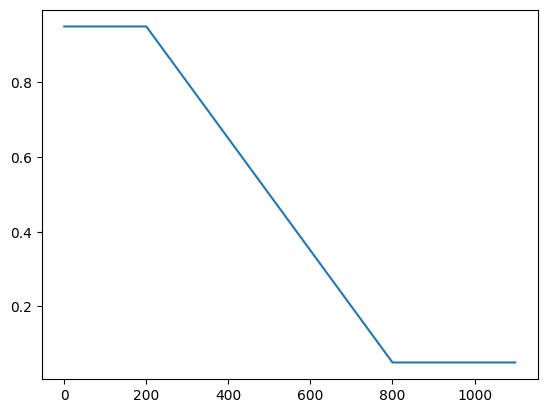

In [7]:
# TEST the epsilon schedule
import matplotlib.pyplot as plt
%matplotlib inline

schedule_linear    = LinearSchedule(start_epsilon=0.95, final_epsilon=0.05, pre_train_steps=200, final_exploration_step=800)
test_points_linear = [schedule_linear.value(t) for t in range(1100)]

plt.plot(test_points_linear)
plt.show()

### Deep Q-Network

The original DQN agent included a CNN as shown in the theory part of this notebook. For our task however, a simple MLP with only one hidden layer should be enough. Starting that simple will help you to get other implementation details right. Later on you can easily scale up and switch the MLP for a more powerfull network.

The DQN algorithm requires us to keep two separate networks, namely, a main **Q-Network** and a second **Target-Network**. For that reason lets implement a method `DQN` that builds and returns a model with the keras functional API. The hidden layer should have a `relu` activation, the output layer should have a `linear` activation (these are the predicted Q-Values, don't threshold them). In the main loop set `num_hidden=64`.

<font color="blue"><b>Comment:</b></font> The following function returns a standard keras model with one hidden layer. The number of input, hidden and output neurons are configurable by the user.

In [8]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow import keras

def DQN(name, input_size, hidden_size, output_size):
    model = keras.Sequential([
        Input(shape=(input_size,)),
        Dense(units=hidden_size, activation="relu"),
        Dense(units=output_size, activation="linear")
    ], name=name)
    return model

In [9]:
# TEST your model
Q_test = DQN("test_dqn", 3, 100, 2)
Q_test.summary()
dummy_batch=np.array([[1, 2, 5]])
Q_test(dummy_batch)

Model: "test_dqn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               400       
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 602
Trainable params: 602
Non-trainable params: 0
_________________________________________________________________


<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.09858364,  0.27170956]], dtype=float32)>

### E-Greedy Policy

As in the Q-Learning notebook, let us encapsulate the action selection into a separate method. This time however, selecting a greedy max action requires us to perform a forward pass through the Q-Network. The method per se remains as simple as in the Q-Learning case.

- Remeber to wrap a single observation from the environment in a fake batch `[]` and turn it into a numpy array.
- To get the index of the beste action you can use `tf.argmax`. Make sure to use the proper axis.
- Make sure to unpack the fake batch again. To get the actual value from a tensor you can call `.numpy()`.

<font color="blue"><b>Comment:</b></font> The epsilon greedy function was written to choose a random or a greedy action based on whether the given epsilon value is greater or smaller than a random value between 0 and 1 chosen by `numpy.random.random()`. We decided to not include a number of actions attribute and instead optain the action count by looking at the number of output neurons of the given Q network. In hindsight this was not necessary as the number of action values is needed often in the main training loop and therefore will aready defined there.

In [10]:
import tensorflow as tf

In [11]:
def choose_egreedy_action(Q, observation, epsilon):
    if np.random.random() < epsilon:
        # Choose a random action with probability epsilon
        action = np.random.randint(Q.layers[-1].output_shape[-1])
    else:
        # Choose the greedy action with probability 1 - epsilon
        q_values = Q(np.array(observation))
        action = np.argmax(q_values)

    return action

### Update the Target Network

As explained in the theory part, the Target-Network will be fixed for some time steps $C$ while the main Q-Network gets update every training/update step. Every $C$ time steps however, we want to update the Target-Network with the latest information from the Q-Network. This basically means that we want to copy over all weights from the Q-Network and assign them to the Target-Network. The Q-Network itself remains unchanged. We will control this freeze frequency later inside the main loop and execute the copy process only every $C$ time steps.

The implementation for this is pretty simple in keras. You can use the `get_weights()` and `set_weights()` methods. Even though it is easy, make sure to test if everything works as intendet, e.g. print the network weights befor and after the call to `update_target`.

In [12]:
def update_target(Q, T):
    T.set_weights(Q.get_weights())

<font color="blue"><b>Comment:</b></font> Below we tested our `update_target()` function to make sure it works properly before training begins. We can see that the weights get copied over from the Q-Network to the T-Network without issues.


In [13]:
import tensorflow as tf
tf.keras.backend.clear_session()

q_dummy = DQN(name="q", input_size=1, hidden_size=2, output_size=2)
t_dummy = DQN(name="t", input_size=1, hidden_size=2, output_size=2)
 
# TEST the function by inspecting the weights of small dummy networks
print("Q-Network weights:\n", [layer.tolist() for layer in q_dummy.get_weights()])
print("T-Network weights:\n", [layer.tolist() for layer in t_dummy.get_weights()])

# Update and print again
print("\nAfter target network update:")
update_target(q_dummy, t_dummy)
print("Q-Network weights:\n", [layer.tolist() for layer in q_dummy.get_weights()])
print("T-Network weights:\n", [layer.tolist() for layer in t_dummy.get_weights()])

Q-Network weights:
 [[[-0.44966739416122437, -0.0774850845336914]], [0.0, 0.0], [[0.19717693328857422, -1.0666766166687012], [-0.11333417892456055, -0.39048951864242554]], [0.0, 0.0]]
T-Network weights:
 [[[-0.7793363332748413, -0.7712350487709045]], [0.0, 0.0], [[1.0107892751693726, 0.9372848272323608], [0.8248814344406128, -0.00610196590423584]], [0.0, 0.0]]

After target network update:
Q-Network weights:
 [[[-0.44966739416122437, -0.0774850845336914]], [0.0, 0.0], [[0.19717693328857422, -1.0666766166687012], [-0.11333417892456055, -0.39048951864242554]], [0.0, 0.0]]
T-Network weights:
 [[[-0.44966739416122437, -0.0774850845336914]], [0.0, 0.0], [[0.19717693328857422, -1.0666766166687012], [-0.11333417892456055, -0.39048951864242554]], [0.0, 0.0]]


### Q-Learning Calculations

So far, everything should have been more or less straightforward. Now we have to calculate the actuall loss and train the networks. Remember to use the Target-Network to calculate the **TD-Target** and the Q-Network to calculate the actual loss of the **TD-Error**. Here are the two equations we have to implement.  

##### TD-Target

$$\begin{eqnarray} 
y_i = r_{t+1} + \gamma \max_a \underbrace{Q(s_{t+1}, a; \theta^{-}_{i})}_{Target-Network}
\end{eqnarray}$$

Make sure to use `next_states` and not the `states` in this calculation. Also, we only want to consider Q-Values if the `next_state` was not terminal. We can do this with the `done` variable and a little trick. In the implementation, simply append `tf.abs(done - 1.0)` to the multiplication. If `done` was `True` this will result in a multiplication by `0` and we don't have to implement a nasty if statement. To get the max Q-Value you can use `tf.reduce_max` on the correct axis.

##### Loss (TD-Error)

Now that we have our targets $y_i$ we can calculate the the TD-Error and the mean square error as our loss function.

$$\begin{eqnarray} 
L_i(\theta_{i}) = \mathbb{E}_{(s,a,r,s') \sim U(\mathcal{D})} \Bigg[ \Bigg( y_i - \underbrace{Q(s_t, a_t;\theta_i)}_{Q-Network} \Big)^2 \Bigg]
\end{eqnarray}$$

Note that in this calculation we don't want to use the max Q-Values but the value from the action that was taken in this example. Again we can use a little trick and use a one-hot encoding of the historical actions to mask the output of the Q-Network. First use `tf.one_hot` with the actions to create the mask, then multiply it with the Q-Values and use `tf.reduce_sum` to get the values of the desired actions. Again, make sure to provide the proper axis. The rest is almost straigtforward. Calculate the loss on the td-error as mean squared error and use it in the code skeleton below to train the Q-Network.

### Train Method

Here is a code little skeleton to help you implement the loss and training procedue step by step. The scope `tf.GradientTape()` tracks the gradients of the loss calculation with respect to the model parameters. Finally we apply those gradients using the optimizer. If everything works you can comment in the `@tf.function` decorator which compiles the whole thing to a tensorflow operation which results in a significant speed up. Since it is hard to test this function manually, just include it in the main loop and react to errors or strange training behavior.

Musste zu class weil sonst tf singleton error gibt wenn mehrere modelle mit dieser function trainienrt werden wollen

<font color="blue"><h3>CLASS: Trainer</h3></font>

During training we discovered a problem with our initial training function. When attempting to train multiple models, the notebook would regularly crash because of a `Singleton` Error. After doing research, we discovered that the reason for this is the `tf.function` wrapper which can't recieve different Q and T Models after it has be initialized. Without re-running the function before a second model gets trained, it would throw the `Singleton` error. We considered removing the `tf.function` wrapped, but we did not want to loose the speedup provided by it during training. To fix this issue, we decided to wrap the `train()` function in a trainer class called `DQNTrainer`. By initializing a new trainer class for every training run, the Q, T, and compiler arguments were moved from a function to a class variable. This way we were able to run multile trainings consecutively and benefit from the speed increase of `@tf.function` as well.  <br>

The calculation of the loss was later expanded during the further experiment phase, which introduced the Huber loss as an alternative loss calculation. To include huber loss, we added the `huber_loss` and `delta` attributes to the `train()` function. <br>

With the later expansion the function/class has the following attributes:

* `Q` = Q-Network
* `T` = Target-Network
* `optimizer` = keras optimizer class
* `gamma` = Importance of long term reward (Discount factor)
* `num_actions` = The number of actions the model can take
* `batch` = A batch of input data containing **states**, **actions**, **rewards**, **next_states**, and inforamtion if the **game is over**.
* `huber_loss` = Optionally set to true to calculate the huber loss
* `delta` = Delta parameter of the huber loss calculation

In [14]:
class DQNTrainer:
    def __init__(self, Q, T, optimizer):
        self.Q = Q
        self.T = T
        self.optimizer = optimizer
    
    @tf.function
    def train(self, gamma, num_actions, batch, huber_loss=False, delta=1.0):
        # 1. unpack the values from batch (as returned by the ReplayBuffer), e.g. observations, actions, etc.
        states, actions, rewards, next_states, dones = batch

        # 2. calculate the td-target
        td_target = rewards + gamma * tf.reduce_max(self.T(next_states), axis=1) * (1 - dones)

        # 3. calculate the td-error and the mean squared loss within the GradientTape.
        with tf.GradientTape() as tape:
            action_mask = tf.one_hot(actions, num_actions)
            q_values = tf.reduce_sum(self.Q(states) * action_mask, axis=1)
            # q_values = tf.reduce_sum(q_values, axis=1)

            # calculate the td-error
            td_error = td_target - q_values
            # calculate the mean squared loss
            if huber_loss:
                h_loss = tf.where(tf.abs(td_error) < delta, tf.square(td_error) * 0.5, delta * (tf.abs(td_error) - 0.5 * delta))
                loss = tf.reduce_mean(h_loss)
            else:
                loss = tf.reduce_mean(tf.square(td_error))
            
        # 4. one update step
        grads = tape.gradient(loss, self.Q.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.Q.trainable_weights))

### Main Loop

Now that we have all parts together, we can implement the main loop. Below is the pseudo code of the Deep Q-Learning Algorithm. The individual parts should look now familiar to you since we have implemented them step by step. Next we have to integrate all parts in the Agent-Environment loop. Ideally you start with a random agent and add the functions one by one. Remember to:

- set `observation = new_observation`
- train only after `t > pre_training_steps`. You also might want to control the training frequency.
- update the target network only after `t > pre_training_steps` and then only every $C$ steps.
- use the AdamOptimizer
- track the training progress by collecting the rewards, you might also calculate a running mean of the last 10 and 100 rewards
- from time to time, print the mean rewards to see the progress
- use the pseudo code as a guide if you get lost

---
##### Deep Q-Learning with experience replay

- Initialize replay memory $D$ to capacity $N$
- Initialize action-value function $Q$ with random weights $\theta$
- Initialize target action-value function $\hat{Q}$ with random weights $\theta^{-}$

- **For** $t = 1, T$ **do**
    - With probability $\epsilon$ select a random action $a_t$
    - otherwise select $a_t = \text{arg}\max_a Q(s_t,a;\theta)$
    <br><br>
    - Execute action $a_t$ in emulator and observe reward $r_t$ and state $s_{t+1}$
    - Store transition $(s_t,a_t,r_t,s_{t+1})$ in $D$
    - Sample random minibatch transitions $(s_j,a_j,r_j,s_{j+1})$ from $D$
    - set    
    $
    y_j = \begin{cases}
          r_j  & \text{if episode terminates at step } j + 1 \\               
          r_j + \gamma \max_a \hat{Q}(s_{j+1}, a; \theta^{-})  & \text{otherwise}
        \end{cases}
$
    
    - Perform a gradient descent step on $\big(y_j - Q(s_j,a_j;\theta)\big)^2$ with respect to the network parameters $\theta$
    - Every $C$ steps reset $\hat{Q} = Q$
- **End For**
---

Here are some default hyperparameters that should work fairly well. Training should run no longer than a few minutes even on a CPU.

- Epsilon Schedule: `start_epsilon=1, final_epsilon 0.02, pre_training_steps=1000, final_exploration_step=10000`
- Replay Buffer: `buffer_size=50000`
- Training: `T=40000, training_freq=1, update_feq=500, batch_size=32`
- Q-Learning: `gamma=0.99`
- DQN: `num_hidden=64`
- Optimizer: `learning_rate=0.001`


In [15]:
from IPython.display import clear_output
import copy

### Plot statistics

Plot the reward per episode and potentially a running mean over 10 and 100 episodes to get smoother curves.

<font color="blue"><h3>FUNCTION: Plot performance measures</h3></font>
*(This section was moved up from below the main function because we wanted to use the plotting function during training)* <br><br>
The main purpose of this function is to provide relevant information about an ongoing training run. We decided to display the **reward per episode** as well as the **epsilon decay history** as plots during training. We adapted the suggestion in the task to display the mean over 10 or 100 episodes to display the **mean over a variable amount of episodes** configurable by the user. This moving average is layed ontop of the exact reward values in the plot and can be disabled by not defining a value for the `display_mov_avg` attribute.

In [16]:
def plot_train_perf(reward_per_episode, epsilon_schedule, t, display_mov_avg=10):
    fig = plt.figure(figsize=(13,4))
    fig.suptitle(f"Training Performance after {t} Steps", fontsize=15, y=1.02)
    
    # Reward plot
    fig.add_subplot(1, 2, 1)
    plt.plot(reward_per_episode, "grey", alpha=0.5)
    plt.title("Reward per Episode", fontsize=13)
    plt.ylabel("Reward")
    plt.xlabel("Episode")
    
    # Calculate average for rewards
    if display_mov_avg:
        moving_average = np.convolve(np.array(reward_per_episode), np.ones(display_mov_avg), mode='valid') / display_mov_avg
        plt.plot(moving_average, "g", label=f"Moving Average of {display_mov_avg}")
        plt.legend(loc="upper left")
    
    # Epsilon Decay plot
    fig.add_subplot(1, 2, 2)
    plt.plot([epsilon_schedule.value(t) for t in range(t)], "orange")
    plt.title("Epsilon Decay", fontsize=13)
    plt.xlabel("Step")
    plt.ylabel("Epsilon")
    
    plt.show()

<font color="blue"><h3>FUNCTION: Main Training</h3></font>
The function `complete_training()` includes a complete training setup and was created to quickly train different agents to test different hyperparameter settings. The function creates all necessary objects such as the **Q- and T- Networks, the optimizer, the replay buffer and various other variables** needed for training. After that, the main agent-environment loop will start and train the model according to the hyperparameters set by the user in the attributes of the function. These configurable attributes include:

* `total_train_steps` = Total training steps
* `batch_size` = Input batch size during training per gradient descent
* `learning_rate` = Learning rate of the Q-Network
* `num_hidden` = Number of neurons in the hidden layer of the DQN
* `gamma` = Discount factor for long term reward
* `update_feq` = Determines how often the weights are copied over from the Q- to the T-Network
* `training_freq` = how many steps should pass per training call (gradient update)
* `buffer_size` = Size of the replay buffer
* `pre_training_steps` = Number of steps with the maximum epsilon value and no training (Used to fill the replay buffer)
* `start_epsilon` = starting value of epsilon during pre-training
* `final_epsilon` = final epsilon value after epsilon decay is finished
* `final_exploration_step` = final step for epsilon decay, where epsilon is not final
* `save_model_name` = filename for the saved model. Saved in format **.h5**. Leave blank to avoid saving the model.
* `plot_graphs` = If true, will plot performance graphs every 1.000 steps

The standard values of the attributes were set as the recommended values by the task description.

<font color="blue"><h4>Hypothesis</h4></font>
Before training, we looked into the Cartpole environment  from gym and found out the truncated value is set to 500 steps. We will therefore consider a model to have found the **optimal policy if it can reach 500 steps consistently**. Because the environment looked relatively simple, only consisting of 4 values in the observation space, we set up our hypothesis that the agent will be able to learn the optimal policy (500 steps) with the given hyperparameter values by the task.

In [17]:
def complete_training(total_train_steps=40000, batch_size=32, learning_rate=0.001, num_hidden=64, gamma=0.99, 
                      update_feq=500, training_freq=1, buffer_size=50000, pre_training_steps=1000, start_epsilon=1, 
                      final_epsilon=0.02, final_exploration_step=10000, save_model_name=False, plot_graphs=True):
    
    # 1. Create a new game and save the dimension for actions
    game = gym.make('CartPole-v1', render_mode=None)
    num_of_actions = np.int32(game.action_space.n)
    start_time = time.time()
    
    # 2. Initialize Epsilon Schedule & Replay Buffer
    epsilon_schedule = LinearSchedule(start_epsilon, final_epsilon, pre_training_steps, final_exploration_step)
    replay_buffer = ReplayBuffer(buffer_size=buffer_size)
    
    # 3. Create the DQN Networks
    Q = DQN(name="Q", input_size=4, hidden_size=num_hidden, output_size=2)
    T = DQN(name="T", input_size=4, hidden_size=num_hidden, output_size=2)
    
    # 4. Create optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # 5. Initialize variables & game
    trainer = DQNTrainer(Q, T, optimizer)
    total_reward_per_episode = []
    obs, _ = game.reset()
    total_reward_game = 0

    # 6. Start Agent-Environment loop
    for t in range(total_train_steps):
        # Depending on epsilon, select random or greedy action
        action = choose_egreedy_action(Q=Q, observation=[obs], epsilon=epsilon_schedule.value(t))
        
        # Step forward in simulation
        prev_obs = copy.deepcopy(obs)
        obs, reward, game_over, truncated, info = game.step(action=action)
        total_reward_game += reward

        # Add step to replay buffer
        replay_buffer.add(prev_obs, action, reward, obs, game_over)
        
        # ACTIONS AFTER PRE-TRAINING
        if t > pre_training_steps:
            # Train Q-Net with a sampled batch
            if (t+1)%training_freq == 0:
                trainer.train(gamma=gamma, num_actions=num_of_actions, batch=replay_buffer.sample(batch_size))

            # Update target net
            if (t+1)%update_feq == 0:
                update_target(Q, T)

        # If game is over, reset game and counters
        if game_over or truncated:
            obs, _ = game.reset()
            total_reward_per_episode.append(total_reward_game)
            total_reward_game = 0

        # Display performance plots
        if (t+1)%1000 == 0 and plot_graphs:
            clear_output(wait=True)
            plot_train_perf(total_reward_per_episode, epsilon_schedule, t+1)
    
    # 7. Save model if specified
    if save_model_name:
        keras.models.save_model(Q, f"{save_model_name}.h5")
    
    print(f"Training finished after {round((time.time()-start_time) / 60)} minutes")
    # Return the trained model and the training rewards per episode
    return Q, total_reward_per_episode

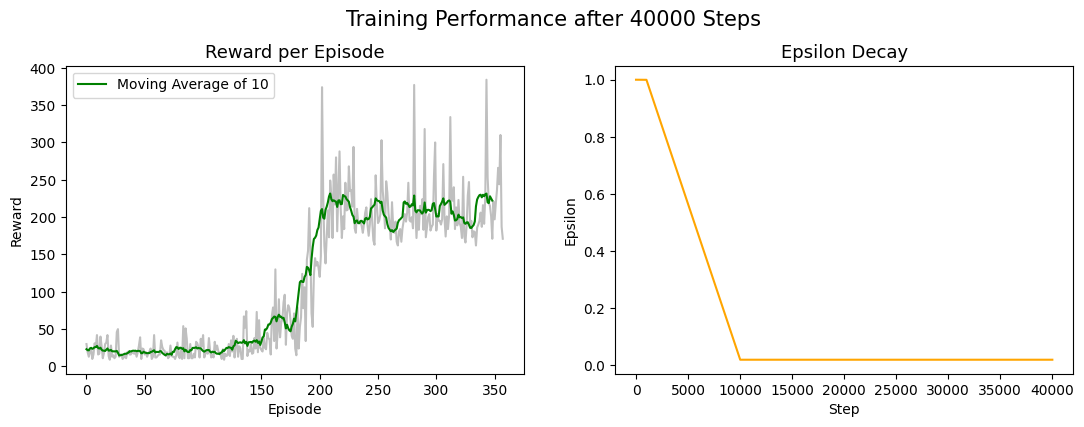

Training finished after 2 minutes


In [18]:
if not only_functions:
    first_trained_model, first_trained_model_rewards = complete_training(save_model_name="first_dqn_model", total_train_steps=40000)

<font color="blue"><h3>Initial Training Analysis</h3></font>
We can see in the final training plot that while the model was able to improve its policy and increase its performance from an average reward of 20 up to 200 per episode, it was not able to reach the truncated limit of 500 reward. Interestingly after episode 200 of the training, the model was not able to improve further and converged at about 200 reward per episode. It should be mentioned that this performance is influenced by the final epsilon value which is not set at zero and could impact the performance through random actions, however one could argue that this is necessary to avoid overfitting and training the model to perform the exact same steps every episode. Further evaluation of the model will be done in the following cells.

<font color="blue"><b>Comment:</b></font> `load_model()` is a small function to load a keras model by name as it was saved in the main training function.

In [19]:
def load_model(model_name):
    return keras.models.load_model(f"{model_name}.h5")

In [20]:
trained_model = load_model("first_dqn_model")

<font color="blue"><h3>FUNCTION: Playing the game with a trained model</h3></font>
After training the agent, we were curious to see it perform in the "game". We wrote a function to take a model and game and let the agent play the game with a fully greedy run of its trained policy. The game will be slowed down and displayed in a separate window by introducing a sleep delay and setting `render_mode="human"` for the user to watch. The attributes are:

* `model` = A trained keras model
* `game` = Game to be played. Needs to be the name of a gym environment

In [21]:
def play_game(model, game='CartPole-v1'):
    test_game = gym.make(game, render_mode="human")

    # Running a random agent on the gym environment
    obs, info = test_game.reset()
    game_over, i = False, 1
    while not game_over:
        action = choose_egreedy_action(Q=model, observation=[obs], epsilon=0)
        obs, reward, game_over, truncated, info = test_game.step(action=action)
        i += 1
        time.sleep(.1)
    
    test_game.close()
    print(f"Game finished after {i} steps")

In [22]:
if not only_functions:
    play_game(trained_model)

Game finished after 287 steps


<font color="blue"><b>Comment:</b></font> We can see in the simulation that the model has learned a good policy for the cartpole environment. It keeps the pole steady throughout. However, we can observe that the cart always drifts to the side very slowly. We can see that the agent has not jet learned an optimal policy as the game ends after about 250 steps because of the cart **driving out of frame**. With this visualization we were able to see why the agent did not reach the trunctated limit of 500 steps. Reaching this limit and overcoming the drifting problem was explored in the further ideas section because it relates strongly to one further ideas task defined as *Can you get a mean 100 test score > 199 / 299 / 399 / 499?*. <br>

<font color="blue"><b>Hypothesis:</b></font>
We assume that the problem of why the agent is not able to learn the optimal policy is the simplicity of the DQN Network. We hypothetise that another hidden layer is needed for the model to accieve an optimal policy (reaching truncated state), because of the deeper structure, it would give the model a better understanding of the current state. For example that the model needs to lean a little bit to the right if the x-position is too much on the left (Will be answered in the further ideas section).

### Evaluation of Deep Reinforcement Learning Algorithms

In general, the evaluation of deep RL is discussed controversially among researchers since it remains unclear how to benchmark and compare such algorithms properly. Is the return or average return a good performance measure? How big is the impact of hyperparameters vs. general algorithm vs. implementation etc.? See the paper [Deep Reinforcement Learning that Matters](https://arxiv.org/abs/1709.06560) from Henderson et al. 2017 for a nice overview of these problems.

As part of this notebook however, we will evaluate our algorithm as done by the authors of DQN. The testing is very simple. Let the trained agent play the game $30$ times with an e-greedy policy with a fixed $\epsilon = 0.05$ and report the average high score (return).

- Run the agent for 30 episodes with an `evaluation_epsilon = 0.05`.
- Plot or print the results in a decent way.

<font color="blue"><h3>FUNCTION: Evaluation</h3></font>
The evaluation function takes a model and game as input and performs a performance evaluation according to the given parameters. These are set by default as **evaluation_epsilon = 0.05** and **total_runs=30**. The final performance metric is the mean reward value of all runs. To speed up the training, the rendering mode was set as `None` to avoid any visuals slowing down the game.

* `model` = A trained keras model
* `game` = Game to be played. Needs to be the name of a gym environment
* `evaluation_epsilon` = Percentage of choosing a random action
* `total_runs` = Number of evaluation training runs 
* `cutoff` = The maximum amount of steps one game can take (The truncated value was deliberately not used to test above the trained limit) 

In [31]:
def evaluate_model(model, game, evaluation_epsilon=0.05, total_runs=30, cutoff=10000):
    total_reward = 0
    test_game = gym.make(game, render_mode=None)
    
    # Play a defined number of test games
    for _ in range(total_runs):
        obs, _ = test_game.reset()
        game_over, cur_round = False, 0
        
        # Playing one game
        while not game_over and cur_round < cutoff:
            action = choose_egreedy_action(Q=model, observation=[obs], epsilon=evaluation_epsilon)
            obs, reward, game_over, truncated, _ = test_game.step(action=action)
            total_reward += 1
            cur_round += 1
    
    # Print and return the result
    print(f"Average Reward of {round(total_reward / total_runs, 2)} after {total_runs} Test Runs")
    return total_reward / total_runs

In [24]:
if not only_functions:
    evaluate_model(trained_model, 'CartPole-v1');

Average Reward of 231.6 after 30 Test Runs


<font color="blue"><b>Comment:</b></font> The evaluation process yields similar results to the initial observation of the training plot. The agent is able to reach an average reward of 231.

<font color="blue"><h3>Testing different Learning rates</h3></font>
As an additional test as part of the main notebook we wanted to test different learning rates to see if it would make a difference in the performance and/or training time, (Further Model optimization will be done in the Further Ideas Section). We chose the learning rate, because we experienced large performance differences in the past notebooks when adjusting this hyperparameter. <br><br>

We assume that a smaller learning rate will increase the performance of the model. This assumtion is based on past experiences in the GAN and Music generation notebooks where smaller learning rates led to better performance. 

In [25]:
if not only_functions:
    model_lr005, model_lr005_rewards = complete_training(save_model_name="model_lr005", total_train_steps=40000, learning_rate=0.005, plot_graphs=False)
    model_lr0005, model_lr0005_rewards = complete_training(save_model_name="model_lr0005", total_train_steps=40000, learning_rate=0.0005, plot_graphs=False)

Training finished after 1 minutes
Training finished after 1 minutes


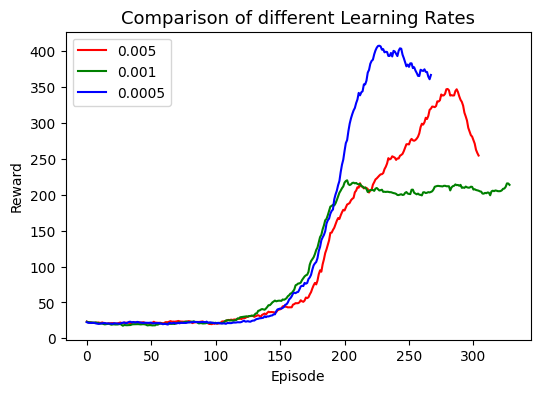

In [26]:
def calc_moving_avg(reward_per_episode, n=30):
    return np.convolve(np.array(reward_per_episode), np.ones(n), mode='valid') / n

if not only_functions:
    # plot the comparison
    plt.figure(figsize=(6,4))
    plt.plot(calc_moving_avg(model_lr005_rewards), "red", label="0.005")
    plt.plot(calc_moving_avg(first_trained_model_rewards), "green", label="0.001")
    plt.plot(calc_moving_avg(model_lr0005_rewards), "blue", label="0.0005")
    plt.title("Comparison of different Learning Rates", fontsize=13)
    plt.ylabel("Reward")
    plt.xlabel("Episode")
    plt.legend()

<font color="blue"><b>Analysis:</b></font>

Our assumtion that a lower learning rate would lead to better performance of the agent was correct, as the best performing model had the lowest learning rate (0.0005) and reached 400 reward per episode in comparison to the first model which had a learning rate of 0.001 and only reached 200 reward per episode. <br><br>
The results suggest that a smaller learning rate was able to overcome the local optimum the initial model got stuck on and reach up to 400 reward per episode.
Surprisingly the model with the highest learning rate came in second in regards to performance. This could be due to better initial random weights and would require more testing to verify. <br><br>
Despite all models training for the same amount of steps we can see that the better performing models ran for less episodes in general. This makes sense as one game takes more steps to finish when the model is performing better.

<font color="blue"><h3>Conclusion</h3></font>
(The conclusion will include findings from the further Ideas section below) <br><br>
In this section we summarize our findings from this assignment:

* We were able to confirm our findings of past assignments that lowering the learning rate can lead to better performance as well as overcomming local optima.
* A significant amount of the training should be spent exploring the environment. Especially with the atari experiment we noticed that more exploration generally led to better performance. The cartpole agent of the main notebook was also benefiting from more exploration and subsequently improved its overall performance
* Hyperparameter tuning is an important part of model training. We learned in the main notebook that changing the hyperparameter without touching the complexitiy of the model can lead to significant performance increases. A bigger model is not always necessary.
* Increasing the batch size significantly increases actual training time (on our hardware) while not improving the steps training time, at least in our scenario. As we discussed this could have been the fault of the low learning rate used.

## Further Ideas

- Experiment with different settings, e.g. extreme buffer sizes for instance.
    - How fast can you train the agent to a test score > 195? In other words, what is the smallest amount of training steps you need to achieve this goal?
    - Can you get a mean 100 test score > 199 / 299 / 399 / 499?
- Implement and experiment with new/different exploration schemes.
- Extend the algorithm to play other gym games or even Atari.

These are just ideas. As always, you can experiment with Hyperparameters/Network sizes but importantly, **reason about their effects etc.**!

## Playing Atari with Deep Reinforcement Learning

So far you have implemented a basic DQN agent. For simplicity we have left out some important details which are crucial in order to play video games. If you are eager to do this anyway here are the missing parts.

### Architecture

First of all, switch the simple MLP with the following architecture from the paper. Note that there are no pooling layers in this CNN!

<img src="./RL_pics/DQN_architecture.png" alt="DQN" style="width: 800px;"/>

### Observability and Preprocessing

We have not talked about observability so far. Formally, Atari video games are Partially Observable Markov Decision Processes or POMDPs. This means that the game screen is not a sufficient observation to fully describe the underlying state and that the Markov Assumption does not hold. A simple example to makes this clear. Think about the game Pong. Given only one frame, the agent has no way of telling if the ball is currently moving from left to right or from right to left. For that reason the authors used the last 4 frames of the game as observation. This turns the POMDP into an MDP again. Furthermore they applied some more preprocessing steps to the game screens such as turning them into gray scale, rescaling, and taking the max out of two subsequent frames. Please see [the methods section of the DQN paper](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning/) for more details on that.

> Hint: In order to implement this you have to keep some sort of frame buffer of the last 4 frames etc.!

### Training Details

In order to play faster, the authors trained the network only every $K=4$ time step. In between, the last taken action was repeated. This allows to play more games, e.g. gather more experience in less time since stepping the emulator forward is computationally *cheaper* than training the network. Again see the paper for details.

During training, the authors clipped the reward to the range $R \in \{-1,0,1\}$. Remember to remove this constraint during testing again to get the *real high score*

Another way to improve training stability was to clip the gradients (or better the squared L2 loss) to the range -1,1. In other words, only apply L2 if the error is inside this range and take a linear loss outside. This corresponds to a Huber Loss. Here you can find a TensorFlow implementations of that from the [OpenAI baseline agents](https://github.com/openai/baselines/blob/24fe3d6576dd8f4cdd5f017805be689d6fa6be8c/baselines/common/tf_util.py#L39). Please read the [Wikipedia](https://en.wikipedia.org/wiki/Huber_loss) to see what the function is doing.

The original DQN implementation used a slightly modified version of RMSProp as its optimizer. You dont have to implement this. It is perfectly fine to stay with Adam for instance. However, be aware that the learning rate is a really crucial parameter in this context. If at least for any, this is definetly the first (and probably the most important) hyperparameter for which you want to test different settings!

### Hyper Parameters

See the paper for a list of good default parameters. Due to the lengthy training times you may want to reduce the total amount of time steps the agent will be trained. You also may adjust the exploration accordingly. However, be aware that exploration time is very important. You may want to benchmark a very short training first and then do some rough calculations of how long it will take to train the agent for some $x$ time steps etc. Then plan some experiments. 

<font color="blue"><h3>1st Further Experiment: Improving the Cartpole Agent</h3></font>
As the first further experiment we choose the first example given: *"Experiment with different settings, e.g. extreme buffer sizes for instance."* and its subquestions:
* How fast can you train the agent to a test score > 195? In other words, what is the smallest amount of training steps you need to achieve this goal?
* Can you get a mean 100 test score > 199 / 299 / 399 / 499?

We will therefore try to improve the inital agent from the main notebook through hyperparameter tuning to accieve **better performance** and **faster training time**. <br>

The hyperparameter tuning was based on the findings of the main notebook, mainly that lowering the learning rate for the agent leads to better performance in the cartpole environment. Several different hyperparameter configurations were tested to improve the performance and consistently reac a max reward per episode of 500. The plot below shows one such tested configuration. In this example, a **longer training time** in comparison with a **longer exploration phase** was tested. This configuration was based on the assumtion that the model was not able to explore enough of the environment in the previous trainings. Other tested configurations include:

* Increasing the amount of hidden neurons to 128
* Increasing/Decreasing the gamma value for long term reward
* Increasing the update frequency to 250 and 100
* Increasing the pre-training phase to 10000 & 20000
* Combinations of the listed hyperparameter changes 

Most configurations resulted in a similar training plot like shown below. These test gave us important information and were enabling us to derive an optimal combination of hyperparameters that were able to reach the optimal reward value in training. This final model will be described in the following cells.

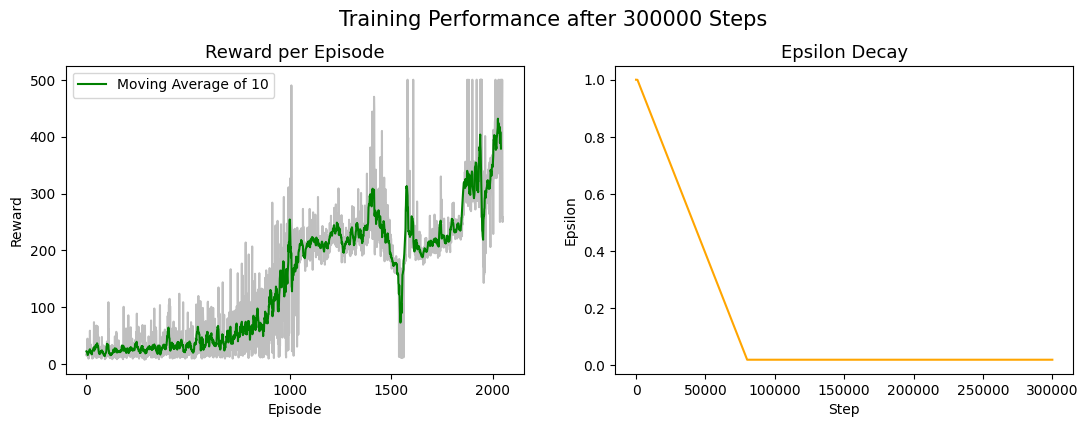

Training finished after 12 minutes


In [27]:
# Example run to optimize hyperparameters
if not only_functions:
    model_lr0005_long, model_lr0005_long_rewards = complete_training(save_model_name="model_lr0005_long", 
                                                                     total_train_steps=300000,
                                                                     final_exploration_step=80000,
                                                                     learning_rate=0.0005)

<font color="blue"><b>Comment:</b></font> In the cell below, the final model with optimized hyperparameters was trained. We can see in the plot that the model was able to reach 500 reward per episode consistently at the end of training. The hyperparameter configuration that we derived at that accieved the best performance was: 
* Keeping the learning rate low at 0.0005
* Increasing the final exploration step and allowing for more exploration durign training
* Increasing the pre-training steps to fill the Replay buffer with more examples before beginning training
* Increasing the final epsilon value to 0.05 to enable more random actions after the exploration phase

We suspect that this hyperparameter configuration led to the best model because we increased the importance of exploration. Especially increasing the final epsilon value. In the plot we can see that this model was stuck at a local optimum too at about 1500 episodes, but was able to overcome it eventually and reached optimal performance. We think that this was caused by the higher chance of a random action through increasing the final epsilon value and by that enabling the model to find a way out of the local optimum.

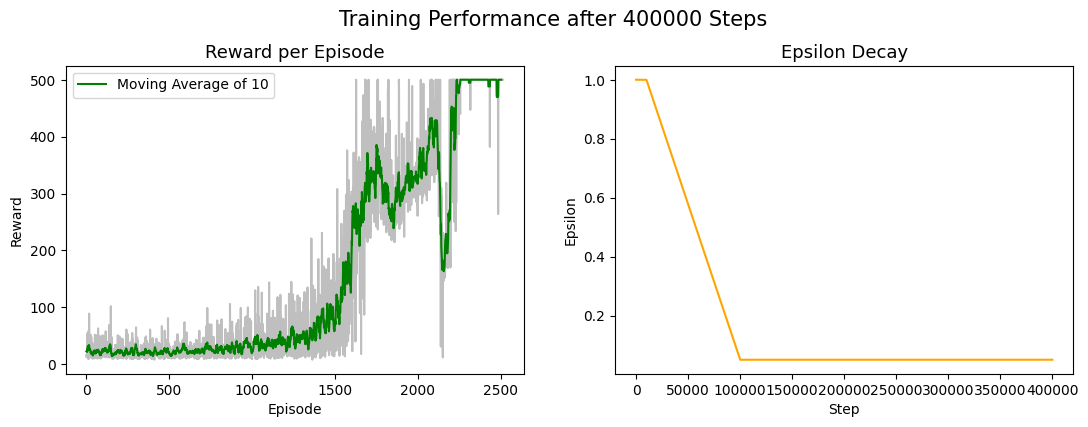

Training finished after 16 minutes


In [28]:
if not only_functions:
    model_lr0005_long_eps, model_lr0005_long_eps_rewards = complete_training(save_model_name="model_lr0005_long_eps", total_train_steps=400000, learning_rate=0.0005, final_exploration_step=100000, final_epsilon=0.05, pre_training_steps=10000)

bumps cönnten scenarien im buffer sein die noch nicht vorkamen

In [32]:
if not only_functions:
    evaluate_model(model_lr0005_long_eps, 'CartPole-v1')

Average Reward of 10000.0 after 30 Test Runs


<font color="blue"><b>Comment:</b></font> While trying to evaluate the last iteration of our model, we waited for half an hour for the evaluation function to finish. We had to abort the execution and had to alter our evaluation function to have a set limit. We didnt want to use the standard truncated value of 500 as we felt it was too low and we wanted to see if the model was able to perform bejond the training scope. A standard cutoff point at 10000 was implemented into the function. With this limit the evaluation was able to complete The result show clearly that the model was able to learn the **optimal policy** with all 30 runs reaching the set limit of 10000 steps. <br>

<font color="blue"><b>Analysis:</b></font> 
In this regard we can say that our assumtion after the first training about needing more hidden layers was wrong and an optimal policy can be accieved with only one hidden layer and the correct hyperparameter tuning. The substatial difference in performance with different hyperparameters showed us the importance of choosing the right hyperparameters and made clear that a bigger model is not always necessary when trying to improve the agent.

<font color="blue"><h4>Improving training time</h4></font>
As the model took many training steps to reach the optimal policy, we set a goal to decrease the training time of the model. Our assumtion was that a larger batch size would expose the model to more training data per step und would lead to faster training time. We terefore trained 5 models with increasing batch sizes and compared the performance and training time. Training time was analysed by looking at the total training steps needed as well as the actual time it takes the model to train, as we assume a larger batch size would result in slower training because of the more complicated calcualtion of the gradients during training.

In [38]:
# Retraining of the initial batch size
if not only_functions:
    final_model_batch_32, final_model_batch_32_rewards = complete_training(save_model_name="final_model_batch_32", batch_size=32, total_train_steps=100000, learning_rate=0.0005, final_exploration_step=100000, final_epsilon=0.05, pre_training_steps=10000, plot_graphs=False)

Training finished after 3 minutes


In [34]:
# Training with larger batch sizes
if not only_functions:
    final_model_batch_64, final_model_batch_64_rewards = complete_training(save_model_name="final_model_batch_64", batch_size=64, total_train_steps=100000, learning_rate=0.0005, final_exploration_step=100000, final_epsilon=0.05, pre_training_steps=10000, plot_graphs=False)
    final_model_batch_256, final_model_batch_256_rewards = complete_training(save_model_name="final_model_batch_256", batch_size=256, total_train_steps=100000, learning_rate=0.0005, final_exploration_step=100000, final_epsilon=0.05, pre_training_steps=10000, plot_graphs=False)
    final_model_batch_1024, final_model_batch_1024_rewards = complete_training(save_model_name="final_model_batch_1024", batch_size=1024, total_train_steps=100000, learning_rate=0.0005, final_exploration_step=100000, final_epsilon=0.05, pre_training_steps=10000, plot_graphs=False)
    final_model_batch_2048, final_model_batch_2048_rewards = complete_training(save_model_name="final_model_batch_2048", batch_size=2048, total_train_steps=100000, learning_rate=0.0005, final_exploration_step=100000, final_epsilon=0.05, pre_training_steps=10000, plot_graphs=False)

Training finished after 3 minutes
Training finished after 4 minutes
Training finished after 11 minutes
Training finished after 56 minutes


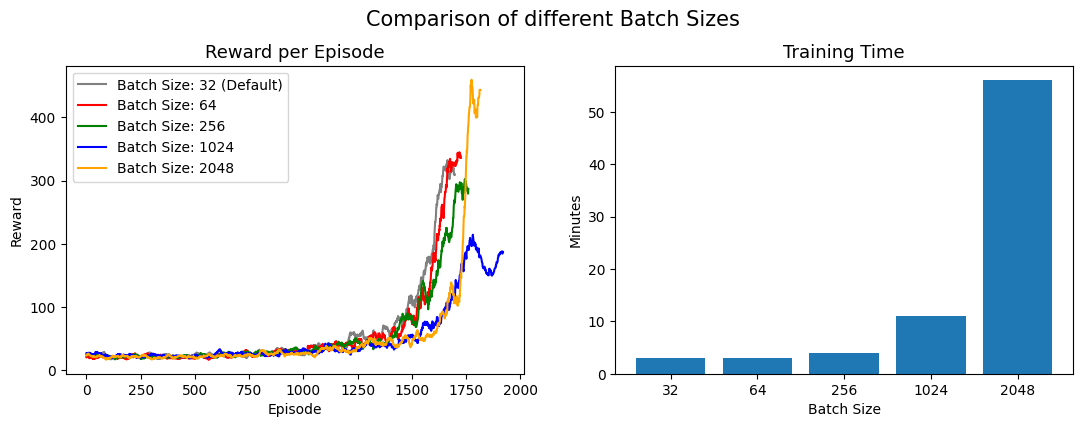

In [43]:
if not only_functions:
    fig = plt.figure(figsize=(13,4))
    fig.suptitle("Comparison of different Batch Sizes", fontsize=15, y=1.02)
    
    # Reward plot
    fig.add_subplot(1, 2, 1)
    plt.plot(calc_moving_avg(final_model_batch_32_rewards), "grey", label="Batch Size: 32 (Default)")
    plt.plot(calc_moving_avg(final_model_batch_64_rewards), "red", label="Batch Size: 64")
    plt.plot(calc_moving_avg(final_model_batch_256_rewards), "green", label="Batch Size: 256")
    plt.plot(calc_moving_avg(final_model_batch_1024_rewards), "blue", label="Batch Size: 1024")
    plt.plot(calc_moving_avg(final_model_batch_2048_rewards), "orange", label="Batch Size: 2048")
    plt.title("Reward per Episode", fontsize=13)
    plt.ylabel("Reward")
    plt.xlabel("Episode")
    plt.legend()
    
    # Epsilon Decay plot
    fig.add_subplot(1, 2, 2)
    plt.bar(["32", "64", "256", "1024", "2048"], [3, 3, 4, 11, 56])
    plt.title("Training Time", fontsize=13)
    plt.ylabel("Minutes")
    plt.xlabel("Batch Size")

    plt.show()

<font color="blue"><b>Analysis:</b></font> 
The results of the batch size comparison can be seen in the plots above. We can see that the time to train the model in regards to needed training steps does not differ significantly. In this regard our assumption was wrong that a larger batch size would train the model quicker. One possible reason why the training time did not improve could be that we would have to increase the learning rate as well for the model to take advantage of the larger dataset per gradient decent. However as we learned in the trainings before, a slower learning rate generally results in a better performing model. This assumtion could be evaluated in future experiments with a possible grid search for better comparison. <br>

The second aspect we compared were the actual training times. Here we observed a huge difference especially in the very high bathc size models. While a model with 32, 64, or 256 entries per batch took less than 10 minutes to train, a batch size of 2048 increased the training time to almost an hour! While we suspected that the actual training time would increase with larger batch sizes, we did not expect such a huge difference. We suspect that this result is partly to blame on the way we trained the model as we used a CPU, which can't compute as much calculations in parallel as a GPU could. Further testing could be done to compare the increases in training time with larger batch sizes in regards to the training hardware used.

<font color="blue"><h3>2nd Further Experiment: Playing Atari Games</h3></font>
As the second experiment we chose to train an agent on atari environments <br>

For this experiment a convolutional neural net function was written that outputs a keras CNN model. 

In [31]:
from tensorflow.keras.layers import Conv2D, Flatten

In [32]:
def DQCNN(name, input_size, output_size):
    model = keras.Sequential([
        Input(shape=input_size),  # (height, width, channels)
        Conv2D(filters=32, kernel_size=8, strides=4, activation="relu"),
        Conv2D(filters=64, kernel_size=4, strides=2, activation="relu"),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        Flatten(),
        Dense(units=512, activation="relu"),
        Dense(units=output_size, activation="linear")
    ], name=name)
    return model

In [33]:
if not only_functions:
    cnn_model = DQCNN(name="CNN", input_size=(84, 84, 4), output_size=14)
    cnn_model.summary()

In [34]:
import cv2

In [35]:
if not only_functions:
    test_game = gym.make("ALE/SpaceInvaders-v5", render_mode="human", obs_type="grayscale")

    print("Action Space:\n", test_game.action_space.n)
    print("Observation Space:\n", test_game.observation_space.shape)

    # Running a random agent on the gym environment
    obs, info = test_game.reset()
    game_over = False

    plt.imshow(obs, cmap="Greys")
    plt.show()

    while not game_over:
        obs, reward, game_over, truncated, info = test_game.step(action=random.randint(0, test_game.action_space.n-1))
        time.sleep(.01)

<font color="blue"><b>Comment:</b></font> To test if the atari game gets loaded correctly, we run one game with random actions. We decided to test the game "Space Invaders" first.

In [36]:
if not only_functions:
    resized = cv2.resize(obs, (64, 64))
    print(type(resized))
    plt.title("Resized observation")
    plt.imshow(resized, cmap="Greys")
    plt.show()

<font color="blue"><h3>FUNCTION: Plotting the frame buffer</h3></font>

It took some time for us to understand the concept of the frame buffer and especially in which dimension configuration to input to the model. To better debug our implementation and verify that the frame buffer works correctly in our training function, we wrote the `plot_frame_buffer` function that displays the 4 frames of the frame buffer after they have been converted to the input dimensions of the model. This plotting function gets called in addition to the performance plotting function (described earlier) during training. This way we can see the content of the converted input tensor. In the course of implementation we tried several different approaches to transform the observations such as `np.expand_dims()`. In our final implementation we use a deque and convert its content through `tf.stack()` and `tf.cast()` to a compatible input tensor.

In [37]:
def plot_frame_buffer(obs):
    fig = plt.figure(figsize=(13,3))
    fig.suptitle("Frame Buffer", fontsize=15)
    
    fig.add_subplot(1, 4, 1)
    plt.imshow(obs[:,:,0], cmap="Greys")
    plt.axis('off')
    fig.add_subplot(1, 4, 2)
    plt.imshow(obs[:,:,1], cmap="Greys")
    plt.axis('off')
    fig.add_subplot(1, 4, 3)
    plt.imshow(obs[:,:,2], cmap="Greys")
    plt.axis('off')
    fig.add_subplot(1, 4, 4)
    plt.imshow(obs[:,:,3], cmap="Greys")
    plt.axis('off')
    
    plt.show()

<font color="blue"><h3>FUNCTION: Complete training for Atari Games</h3></font>
This function is a modified and expanded version of the `complete_training()` function of the main notebook. Changes include:

* Adding a Frame Buffer and converting the observations of the environment to the desired shape for the model input. The Frame buffer was realized with a deque structure and stores the last frames of the game. If a new game is started, we decided to repeat the first frame instead of filling the buffer with zeros, as we felt is was closer to typical state values than zeros.

* The model will now be saved reguraly during training instead of just the end, because training the atari games took a long time and we did not want to loose progress incase the kernel dies.

* The frame buffer gets displayed alongside the performance metric plots to get a sample of current states the agent is in. This way we were able to see for example, how many of the aliens the agent had destroyed in space invaders.

Alongside these changes some new attributes were introduced:

* `frames_per_obs` = Size of the frame buffer (Amount of last frames given to the agent as input)
* `use_huber_loss` = Option to enable the alternative huber loss for training. Inspired by the linked paper by deepmind.
* `pretrained_weights` = The function was expanded to be able to get pretrained weights and resume training of a previous training run.

In [41]:
def atari_complete_training(game, total_train_steps=40000, batch_size=32, learning_rate=0.001, gamma=0.99, obs_size=64, 
                            frames_per_obs=4, update_feq=500, training_freq=1, buffer_size=50000, pre_training_steps=1000, 
                            start_epsilon=1, final_epsilon=0.02, final_exploration_step=10000, save_model_name=False, 
                            use_huber_loss=False, pretrained_weights=False):
    
    # 1. Create a new game and save the dimension for actions
    game = gym.make(game, render_mode=None, obs_type="grayscale")
    num_of_actions = np.int32(game.action_space.n)
    
    # 2. Initialize Epsilon Schedule & Replay Buffer
    epsilon_schedule = LinearSchedule(start_epsilon, final_epsilon, pre_training_steps, final_exploration_step)
    replay_buffer = ReplayBuffer(buffer_size=buffer_size)
    
    # 3. Create the DQN Networks. The input size is determined by the obs_size and the frames_per_obs
    Q = DQCNN(name="Q", input_size=(obs_size, obs_size, frames_per_obs), output_size=num_of_actions)
    T = DQCNN(name="T", input_size=(obs_size, obs_size, frames_per_obs), output_size=num_of_actions)
    # If pretrained model is given, carry over the weights
    if pretrained_weights:
        update_target(pretrained_weights, T)
        update_target(pretrained_weights, Q)
        print("Loaded weights from pretrained input")
    
    # 4. Create optimizer & compile models
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # 5. Initialize variables & game
    trainer = DQNTrainer(Q, T, optimizer)
    total_reward_per_episode = []
    obs, _ = game.reset()
    total_reward_game = 0
    
    # 5.5 Additions in Atari training: 
    last_x_frames = deque(maxlen=frames_per_obs)  # Deque to hold the last frames
    obs = cv2.resize(obs, (obs_size, obs_size))  # Resizing the observation
    obs = obs.astype(np.float64) / 255
    
    # Initially fill the queue with the first frame 
    for _ in range(frames_per_obs):
        last_x_frames.append(obs)
    # Convert the frames queue to a observation. Reshaping also needed
    frames_obs = tf.stack(list(last_x_frames), axis=-1)  # Stack frames along the last dimension
    frames_obs = tf.cast(frames_obs, tf.float32)  # Cast to float32

    # 6. Start Agent-Environment loop
    for t in range(total_train_steps):
        # Depending on epsilon, select random or greedy action
        action = choose_egreedy_action(Q=Q, observation=[frames_obs], epsilon=epsilon_schedule.value(t))
        
        # Step forward in simulation
        prev_obs = copy.deepcopy(frames_obs)
        obs, reward, game_over, truncated, info = game.step(action=action)
        obs = cv2.resize(obs, (obs_size, obs_size))
        obs = obs.astype(np.float64) / 255
        total_reward_game += reward
        last_x_frames.append(obs)  # Add observation to last frames buffer
        
        #frames_obs = np.dstack([i for i in list(last_x_frames)])
        frames_obs = tf.stack(list(last_x_frames), axis=-1)  # Stack frames along the last dimension
        frames_obs = tf.cast(frames_obs, tf.float32)  # Cast to float32
        
        # Add step to replay buffer
        replay_buffer.add(prev_obs, action, reward, frames_obs, game_over)
        
        # ACTIONS AFTER PRE-TRAINING
        if t > pre_training_steps:
            # Train Q-Net with a sampled batch
            if (t+1)%training_freq == 0:
                trainer.train(gamma=gamma, num_actions=num_of_actions, batch=replay_buffer.sample(batch_size), huber_loss=True if use_huber_loss else False)

            # Update target net
            if (t+1)%update_feq == 0:
                update_target(Q, T)

        # If game is over, reset game and counters
        if game_over:
            obs, _ = game.reset()
            total_reward_per_episode.append(total_reward_game)
            total_reward_game = 0
            
            # Convert obs
            obs = cv2.resize(obs, (obs_size, obs_size))  # Resizing the observation
            obs = obs.astype(np.float64) / 255
    
            # Refill the queue with the first frame 
            for _ in range(frames_per_obs):
                last_x_frames.append(obs)
                
            # Convert the frames queue to a observation. Reshaping also needed
            frames_obs = tf.stack(list(last_x_frames), axis=-1)  # Stack frames along the last dimension
            frames_obs = tf.cast(frames_obs, tf.float32)  # Cast to float32

        # Display performance plots
        if (t+1)%10000 == 0:
            clear_output(wait=True)
            plot_train_perf(total_reward_per_episode, epsilon_schedule, t+1)
            plot_frame_buffer(frames_obs)
            
            # Save model also during training
            if save_model_name:
                keras.models.save_model(Q, f"{save_model_name}.h5")

    # Final save model if specified
    if save_model_name:
        keras.models.save_model(Q, f"{save_model_name}.h5")

    return Q

<font color="blue"><b>Comment:</b></font> 
Training an agent on an atari game was much more difficult than the Cartpole environment. In our experiment we tested different hyperparameter settings and different games. We ended up using a slightly modified hyperparameter setting than the linked deepmind paper. Apart from there changes the hyperparameters were taken from the paper:
* The update frequency was doubled from every 20000 steps to every 10000 steps. Without this increase, we were not able to notice any policy improvement during training.
* Decreasing the buffer size to 500000. This was necessary to avoid killing the kernel as the RAM requirements were surpassing our available RAM.

Before using the hyperparameters of the paper, we tried to accieve faster training time by increasing the learning rate to 0.001. This however did not result in any noticable policy improvement by the agent.

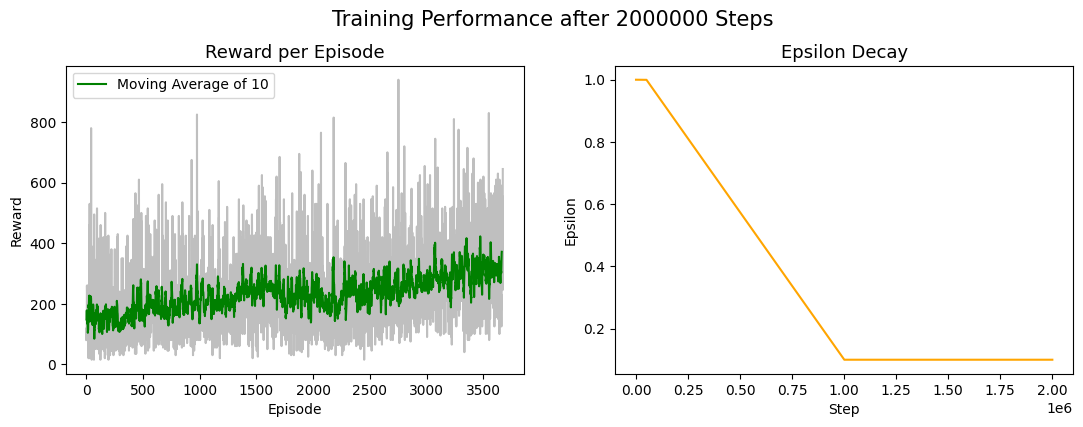

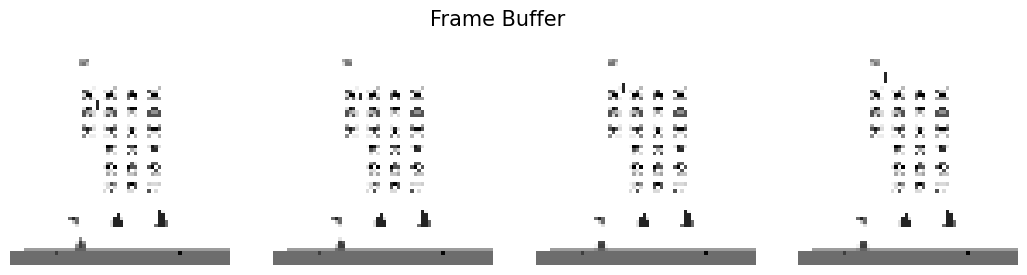

In [39]:
trained_atari_model = atari_complete_training("ALE/SpaceInvaders-v5",
                                              total_train_steps=2000000,
                                              final_exploration_step=1000000,
                                              buffer_size = 500000,
                                              update_feq=10000,
                                              training_freq=4,
                                              learning_rate=0.00025,
                                              use_huber_loss = True,
                                              final_epsilon=0.1,
                                              pre_training_steps=50000,
                                              save_model_name="space_invaders")

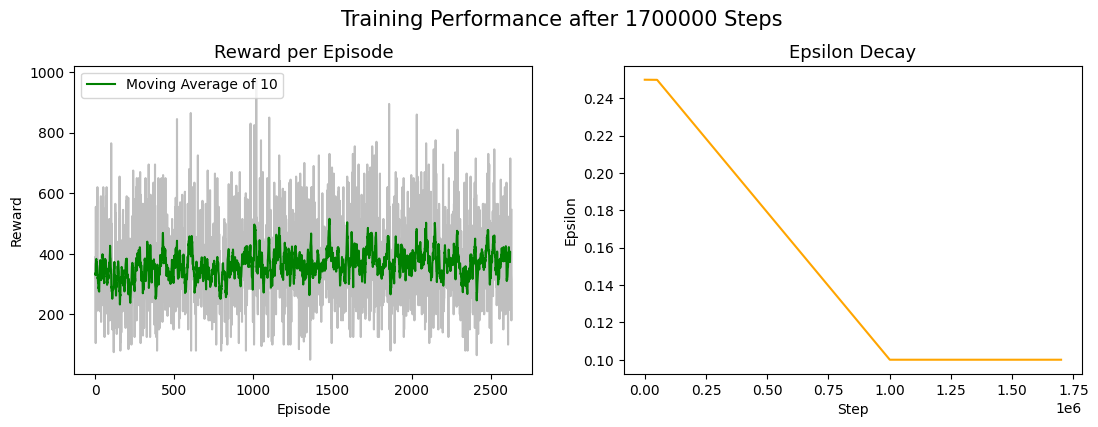

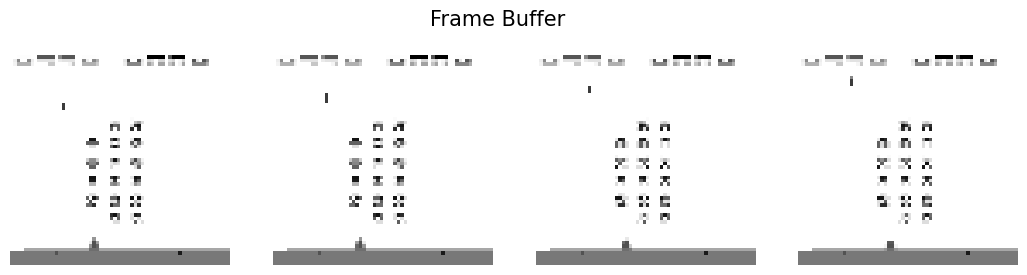

In [ ]:
pretrained_space_inv = load_model("space_invaders")
trained_atari_model = atari_complete_training("ALE/SpaceInvaders-v5",
                                              total_train_steps=3000000,
                                              final_exploration_step=1000000,
                                              buffer_size = 500000,
                                              update_feq=10000,
                                              training_freq=4,
                                              start_epsilon = 0.25,
                                              learning_rate=0.00025,
                                              use_huber_loss = True,
                                              final_epsilon=0.1,
                                              pre_training_steps=50000,
                                              save_model_name="space_invaders_2",
                                              pretrained_weights=pretrained_space_inv)

<font color="blue"><b>Comment:</b></font> The training of the space invaders agent was split into two training runs because of the long time it ended up taking to train. In total we trained for 3.7 million steps and were able to accieve a noticable performance increase by the agent reaching an average reward of 400. We were not able to train the agent further as it took almost 10 hours up to that point. It is possible that the agent would be able to further optimise its policy with further training. <br><br>

To better see the agent perform in the game, we wrote a function that runs an atari game with a trained agent. The performance of our trained agent can be viewed in the included video of our submission. In it we can see that the agent is able to avoid the shots and simultaniously shoot down the aliens to score more points (The recording was not able to capture the shots of the player properly, but the effects can be observed by the destroyed aliens). <br><br> 

We can conclude that the model was able to succesfully improve its decision making in the game space invaders.

In [63]:
def play_atari_game(model, game, frames_per_obs=4, obs_size=64):
    test_game = gym.make(game, render_mode="human", obs_type="grayscale")

    # Running a random agent on the gym environment
    obs, info = test_game.reset()
    game_over, i = False, 1
    
    # Creation of frame buffer
    last_x_frames = deque(maxlen=frames_per_obs)  # Deque to hold the last frames
    obs = cv2.resize(obs, (obs_size, obs_size))  # Resizing the observation
    obs = obs.astype(np.float64) / 255
    # Initially fill the queue with the first frame 
    for _ in range(frames_per_obs):
        last_x_frames.append(obs)
    # Convert the frames queue to a observation. Reshaping also needed
    frames_obs = tf.stack(list(last_x_frames), axis=-1)  # Stack frames along the last dimension
    frames_obs = tf.cast(frames_obs, tf.float32)  # Cast to float32

    while not game_over:
        action = choose_egreedy_action(Q=model, observation=[frames_obs], epsilon=0)
        obs, reward, game_over, truncated, info = test_game.step(action=action)
        i += 1
        
        # Updating frame buffer
        obs = cv2.resize(obs, (obs_size, obs_size))
        obs = obs.astype(np.float64) / 255
        last_x_frames.append(obs)  # Add observation to last frames buffer
        frames_obs = tf.stack(list(last_x_frames), axis=-1)  # Stack frames along the last dimension
        frames_obs = tf.cast(frames_obs, tf.float32)  # Cast to float32
        
        time.sleep(.1)
    
    test_game.close()
    print(f"Game finished after {i} steps")

In [65]:
pretrained_space_inv_2 = load_model("space_invaders_2")
play_atari_game(pretrained_space_inv_2, "ALE/SpaceInvaders-v5")

Game finished after 991 steps


<font color="blue"><b>Comment:</b></font> Below we can see a failed training run with a different atari game (Pong). Serveral different hyperparameter configurations (apart from the one displayed) were tried, namely:
* Lowering the learning rate to 0.00025
* Increasing the buffer_size to 5000000 (1.000.000 was also tried but led to the kernel dying due to not enough RAM)
* Increasing epsilon decay values such as pre training steps and final exploration steps

We are not sure why the model was able to learn the game space invaders but not able to improve its policy for the game pong. One hypothesis we have is that it is easier to score points in space invaders by just shooting up than it is in pong as you need to stand in the exact position to reflect the ball. This could be a possible reason for this problem and would require further testing to overcome.

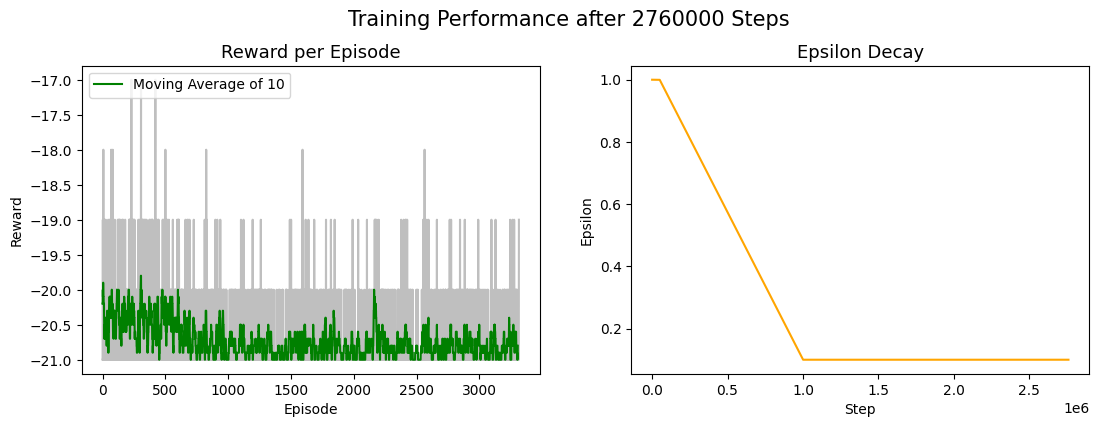

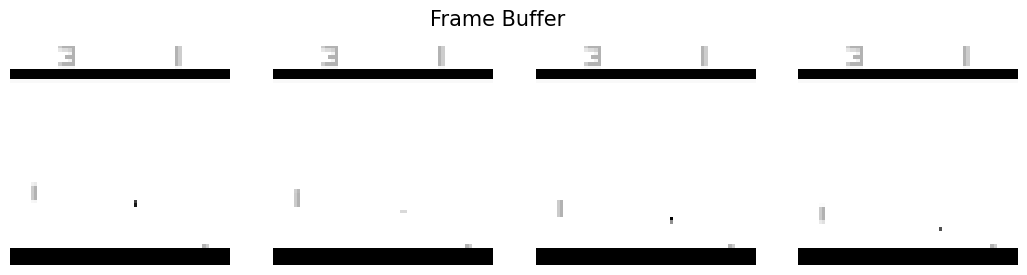

In [ ]:
trained_atari_model = atari_complete_training("ALE/Pong-v5",
                                              total_train_steps=5000000,
                                              buffer_size = 200000,
                                              update_feq=10000,
                                              training_freq=4,
                                              learning_rate=0.0005,
                                              use_huber_loss = True,
                                              final_exploration_step=1000000,
                                              final_epsilon=0.1,
                                              pre_training_steps=50000,
                                              save_model_name="pong")

<font color="blue"><b>Atari Conclusion:</b></font>
In conclusion we can say that training agents to play atari games is much harder that simple environments like cartpole and require significantly more training time.
In our experiment we had mixed results with beeing able to train on some atari games, but failing with others. 